In [1]:
from fastai.vision.all import *
from fastaudio.all import *
from fastai.text.all import *

from thunder_QuartzNet import QuartzNet, conv1d_decoder
from loading_weights import load_quartznet_checkpoint, QuartznetCheckpoint
from transform import FilterbankFeatures

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [2]:
import editdistance
from fastai.callback.wandb import *

In [3]:
path = Path('data/')

In [4]:
labels = pd.read_csv('./dataDS.csv', index_col=0)

In [5]:
CORR = {'h#': "",
 'sh': "ʃ",
 'iy': "i",
 'hv': "ɦ",
 'ae': "æ",
 'dcl': "d̚",
 'd': "d",
 'y': "j",
 'er': "ɝ",
 'aa': "ɑ",
 'r': "r",
 'kcl': "k̚",
 'k': "k",
 's': "s",
 'uw': "u",
 'dx': "ɾ",
 'ih': "ɪ",
 'ng': "ŋ",
 'gcl': "ɡ̚",
 'g': "g",
 'w': "w",
 'epi': "",
 'q': "ʔ",
 'ao': "ɔ",
 'l': "l",
 'axr': "ɚ",
 'ow': "oʊ",
 'n': "n",
 'm': "m",
 'tcl': "t̚",
 't': "t",
 'ix': "ɨ̞",
 'eh': "ɛ",
 'oy': "ɔɪ",
 'ay': "aɪ",
 'dh': "ð",
 'hh': "h",
 'z': "z",
 'pcl': "p̚",
 'ax': "ə",
 'th': "θ",
 'bcl': "b̚",
 'b': "b",
 'ux': "ʉ",
 'f': "f",
 'el': "l̩",
 'v': "v",
 'aw': "aʊ",
 'p': "p",
 'ah': "ʌ",
 'ey': "eɪ",
 'en': "n̩",
 'ch': "tʃ",
 'uh': "ʊ",
 'pau': "",
 'jh': "dʒ",
 'nx': "ɾ̃",
 'ax-h': "ə̥",
 'zh': "ʒ",
 'em': "m̩",
 'eng': "ŋ̩"}

In [6]:
labels

,Path,Transcription
0,.\data\TEST\DR1\FAKS0\SA1.WAV.wav,h#.sh.iy.hv.ae.dcl.d.y.er.dcl.d.aa.r.kcl.k.s.uw.dx.ih.ng.gcl.g.r.iy.s.iy.w.aa.sh.epi.w.aa.dx.er.q.ao.l.y.iy.axr.h#.
1,.\data\TEST\DR1\FAKS0\SA2.WAV.wav,h#.d.ow.n.ae.s.epi.m.iy.tcl.t.ix.kcl.k.eh.r.iy.ix.n.oy.l.iy.r.ae.gcl.g.l.ay.kcl.k.dh.ae.tcl.h#.
2,.\data\TEST\DR1\FAKS0\SI1573.WAV.wav,h#.hh.ih.z.kcl.k.ae.pcl.t.ix.n.w.ax.s.th.ih.n.ae.n.hv.ae.gcl.g.er.dcl.d.ix.n.ih.z.bcl.b.y.ux.dx.ux.f.el.bcl.b.uw.tcl.t.s.epi.w.axr.w.ao.r.n.ix.n.epi.sh.ae.bcl.b.iy.h#.
3,.\data\TEST\DR1\FAKS0\SI2203.WAV.wav,h#.dh.ix.r.iy.z.ax.n.z.f.axr.dh.ih.s.dcl.d.ay.v.s.iy.m.dcl.d.f.uw.l.ix.sh.epi.n.aw.h#.
4,.\data\TEST\DR1\FAKS0\SI943.WAV.wav,h#.p.axr.dcl.d.ah.kcl.k.sh.ix.n.m.ey.f.ao.l.f.aa.r.bcl.b.ax.l.ow.ax.kcl.k.s.pcl.p.ix.kcl.t.ey.sh.en.tcl.s.h#.
...,...,...
6295,.\data\TRAIN\DR8\MTCS0\SX172.WAV.wav,h#.dh.ax.tcl.t.r.ay.ah.m.f.ax.n.q.w.oy.er.ix.gcl.g.z.ih.bcl.b.ix.tcl.t.ih.dcl.n.ay.iy.v.hv.eh.r.ow.ih.z.ax.m.h#.
6296,.\data\TRAIN\DR8\MTCS0\SX262.WAV.wav,h#.k.eh.n.dh.iy.ey.dcl.jh.ih.n.s.iy.ow.v.axr.th.r.ow.ey.l.iy.ix.n.f.ao.r.s.ax.s.h#.
6297,.\data\TRAIN\DR8\MTCS0\SX352.WAV.wav,h#.ax.kcl.k.ao.r.dx.ih.n.dx.ax.m.ay.en.tcl.t.er.pcl.p.axr.tcl.t.ey.sh.en.ax.dh.ax-h.pcl.p.r.aa.bcl.b.em.pau.t.ux.l.ay.n.z.epi.m.ah.s.bcl.b.iy.pcl.p.er.pcl.p.ix.n.dcl.d.ih.kcl.k.ix.l.axr.h#.
6298,.\data\TRAIN\DR8\MTCS0\SX442.WAV.wav,h#.s.ax.bcl.b.er.bcl.axr.n.hv.aw.s.epi.w.ay.v.z.q.ao.f.tcl.t.ix.n.s.ah.f.axr.f.r.ax.m.dh.ix.gcl.g.ae.bcl.b.hv.ae.bcl.b.ix.tcl.t.h#.


In [7]:
def replace_slashes(s:str):
    return s.replace('\\', '/')

In [8]:
labels.Path = labels.Path.map(replace_slashes)

In [9]:
Path(path/labels.Path[0]).is_file()

True

In [10]:
def replace_seqs(s:str):
    return '.'.join([CORR[i] for i in s.split('.') if i and CORR[i]])

In [11]:
replace_seqs(labels.Transcription[2])

'h.ɪ.z.k̚.k.æ.p̚.t.ɨ̞.n.w.ə.s.θ.ɪ.n.æ.n.ɦ.æ.ɡ̚.g.ɝ.d̚.d.ɨ̞.n.ɪ.z.b̚.b.j.ʉ.ɾ.ʉ.f.l̩.b̚.b.u.t̚.t.s.w.ɚ.w.ɔ.r.n.ɨ̞.n.ʃ.æ.b̚.b.i'

In [12]:
labels.Transcription = labels.Transcription.map(replace_seqs)

In [13]:
labels

,Path,Transcription
0,./data/TEST/DR1/FAKS0/SA1.WAV.wav,ʃ.i.ɦ.æ.d̚.d.j.ɝ.d̚.d.ɑ.r.k̚.k.s.u.ɾ.ɪ.ŋ.ɡ̚.g.r.i.s.i.w.ɑ.ʃ.w.ɑ.ɾ.ɝ.ʔ.ɔ.l.j.i.ɚ
1,./data/TEST/DR1/FAKS0/SA2.WAV.wav,d.oʊ.n.æ.s.m.i.t̚.t.ɨ̞.k̚.k.ɛ.r.i.ɨ̞.n.ɔɪ.l.i.r.æ.ɡ̚.g.l.aɪ.k̚.k.ð.æ.t̚
2,./data/TEST/DR1/FAKS0/SI1573.WAV.wav,h.ɪ.z.k̚.k.æ.p̚.t.ɨ̞.n.w.ə.s.θ.ɪ.n.æ.n.ɦ.æ.ɡ̚.g.ɝ.d̚.d.ɨ̞.n.ɪ.z.b̚.b.j.ʉ.ɾ.ʉ.f.l̩.b̚.b.u.t̚.t.s.w.ɚ.w.ɔ.r.n.ɨ̞.n.ʃ.æ.b̚.b.i
3,./data/TEST/DR1/FAKS0/SI2203.WAV.wav,ð.ɨ̞.r.i.z.ə.n.z.f.ɚ.ð.ɪ.s.d̚.d.aɪ.v.s.i.m.d̚.d.f.u.l.ɨ̞.ʃ.n.aʊ
4,./data/TEST/DR1/FAKS0/SI943.WAV.wav,p.ɚ.d̚.d.ʌ.k̚.k.ʃ.ɨ̞.n.m.eɪ.f.ɔ.l.f.ɑ.r.b̚.b.ə.l.oʊ.ə.k̚.k.s.p̚.p.ɨ̞.k̚.t.eɪ.ʃ.n̩.t̚.s
...,...,...
6295,./data/TRAIN/DR8/MTCS0/SX172.WAV.wav,ð.ə.t̚.t.r.aɪ.ʌ.m.f.ə.n.ʔ.w.ɔɪ.ɝ.ɨ̞.ɡ̚.g.z.ɪ.b̚.b.ɨ̞.t̚.t.ɪ.d̚.n.aɪ.i.v.ɦ.ɛ.r.oʊ.ɪ.z.ə.m
6296,./data/TRAIN/DR8/MTCS0/SX262.WAV.wav,k.ɛ.n.ð.i.eɪ.d̚.dʒ.ɪ.n.s.i.oʊ.v.ɚ.θ.r.oʊ.eɪ.l.i.ɨ̞.n.f.ɔ.r.s.ə.s
6297,./data/TRAIN/DR8/MTCS0/SX352.WAV.wav,ə.k̚.k.ɔ.r.ɾ.ɪ.n.ɾ.ə.m.aɪ.n̩.t̚.t.ɝ.p̚.p.ɚ.t̚.t.eɪ.ʃ.n̩.ə.ð.ə̥.p̚.p.r.ɑ.b̚.b.m̩.t.ʉ.l.aɪ.n.z.m.ʌ.s.b̚.b.i.p̚.p.ɝ.p̚.p.ɨ̞.n.d̚.d.ɪ.k̚.k.ɨ̞.l.ɚ
6298,./data/TRAIN/DR8/MTCS0/SX442.WAV.wav,s.ə.b̚.b.ɝ.b̚.ɚ.n.ɦ.aʊ.s.w.aɪ.v.z.ʔ.ɔ.f.t̚.t.ɨ̞.n.s.ʌ.f.ɚ.f.r.ə.m.ð.ɨ̞.ɡ̚.g.æ.b̚.b.ɦ.æ.b̚.b.ɨ̞.t̚.t


In [14]:
transcripts = L(labels.Transcription.values.tolist())

In [15]:
transcripts

(#6300) ['ʃ.i.ɦ.æ.d̚.d.j.ɝ.d̚.d.ɑ.r.k̚.k.s.u.ɾ.ɪ.ŋ.ɡ̚.g.r.i.s.i.w.ɑ.ʃ.w.ɑ.ɾ.ɝ.ʔ.ɔ.l.j.i.ɚ','d.oʊ.n.æ.s.m.i.t̚.t.ɨ̞.k̚.k.ɛ.r.i.ɨ̞.n.ɔɪ.l.i.r.æ.ɡ̚.g.l.aɪ.k̚.k.ð.æ.t̚','h.ɪ.z.k̚.k.æ.p̚.t.ɨ̞.n.w.ə.s.θ.ɪ.n.æ.n.ɦ.æ.ɡ̚.g.ɝ.d̚.d.ɨ̞.n.ɪ.z.b̚.b.j.ʉ.ɾ.ʉ.f.l̩.b̚.b.u.t̚.t.s.w.ɚ.w.ɔ.r.n.ɨ̞.n.ʃ.æ.b̚.b.i','ð.ɨ̞.r.i.z.ə.n.z.f.ɚ.ð.ɪ.s.d̚.d.aɪ.v.s.i.m.d̚.d.f.u.l.ɨ̞.ʃ.n.aʊ','p.ɚ.d̚.d.ʌ.k̚.k.ʃ.ɨ̞.n.m.eɪ.f.ɔ.l.f.ɑ.r.b̚.b.ə.l.oʊ.ə.k̚.k.s.p̚.p.ɨ̞.k̚.t.eɪ.ʃ.n̩.t̚.s','p.i.t̚.s.ɚ.r.i.ɨ̞.z.ɑ.r.k̚.k.ɨ̞.n.v.i.n.j.ɨ̞.n.t̚.f.ɝ.ɨ̞.k̚.k.w.ɪ.k̚.k.l.ʌ.n.t̚.tʃ','p.ʊ.t̚.ð.ə.b̚.b.ʊ.t̚.tʃ.ɚ.b̚.b.l.ɑ.k̚.t.eɪ.b̚.b.l̩.ə.n.ð.ɨ̞.ɡ̚.g.ɝ.ɑ.ʃ','d.r.ɑ.p̚.f.aɪ.v.f.ɔ.r.m.z.ə.n.ð.ə.b̚.b.ɑ.k̚.k.s.b̚.b.ə.f.ɔ.r.j.ɨ̞.ɡ̚.g.oʊ.aʊ.t̚','h.ɝ.w.ɔ.r.d̚.d.r.oʊ.b̚.k.n̩.s.ɪ.s.ə.v.oʊ.n.l.i.s.k̚.k.ɝ.t̚.t.s.ə.n.b̚.b.l.aʊ.s.ɨ̞.ʔ.s','ʔ.ɛ.l.d̚.d.ɝ.l.i.p̚.p.i.p̚.p.l̩.ɝ.ɑ.f.ɨ̞.n.ɨ̞.ʔ.k̚.k.s.k̚.k.l.ʉ.d̚.d.ɨ̞.d̚.d'...]

In [16]:
whole = '.'.join([t for t in transcripts])

In [17]:
whole[:100]

'ʃ.i.ɦ.æ.d̚.d.j.ɝ.d̚.d.ɑ.r.k̚.k.s.u.ɾ.ɪ.ŋ.ɡ̚.g.r.i.s.i.w.ɑ.ʃ.w.ɑ.ɾ.ɝ.ʔ.ɔ.l.j.i.ɚ.d.oʊ.n.æ.s.m.i.t̚.t.'

In [18]:
vocab = L('',*list(whole.split('.')))

In [19]:
vocab = vocab.unique()

In [20]:
vocab

(#59) ['','ʃ','i','ɦ','æ','d̚','d','j','ɝ','ɑ'...]

In [21]:
letter2idx = {letter:idx for (idx,letter) in enumerate(vocab)}

In [22]:
letter2idx

{'': 0,
 'ʃ': 1,
 'i': 2,
 'ɦ': 3,
 'æ': 4,
 'd̚': 5,
 'd': 6,
 'j': 7,
 'ɝ': 8,
 'ɑ': 9,
 'r': 10,
 'k̚': 11,
 'k': 12,
 's': 13,
 'u': 14,
 'ɾ': 15,
 'ɪ': 16,
 'ŋ': 17,
 'ɡ̚': 18,
 'g': 19,
 'w': 20,
 'ʔ': 21,
 'ɔ': 22,
 'l': 23,
 'ɚ': 24,
 'oʊ': 25,
 'n': 26,
 'm': 27,
 't̚': 28,
 't': 29,
 'ɨ̞': 30,
 'ɛ': 31,
 'ɔɪ': 32,
 'aɪ': 33,
 'ð': 34,
 'h': 35,
 'z': 36,
 'p̚': 37,
 'ə': 38,
 'θ': 39,
 'b̚': 40,
 'b': 41,
 'ʉ': 42,
 'f': 43,
 'l̩': 44,
 'v': 45,
 'aʊ': 46,
 'p': 47,
 'ʌ': 48,
 'eɪ': 49,
 'n̩': 50,
 'tʃ': 51,
 'ʊ': 52,
 'dʒ': 53,
 'ɾ̃': 54,
 'ə̥': 55,
 'ʒ': 56,
 'm̩': 57,
 'ŋ̩': 58}

In [23]:
def gggparent_eq(p, gggp = "TEST"):
    return Path(p).parent.parent.parent.name == gggp

In [24]:
labels["is_valid"] = labels.Path.map(gggparent_eq)

In [25]:
Audio(path/labels.Path[2])

In [26]:
# {'sample_rate': 16000, 'n_window_size': 320, 'n_window_stride': 160, 'n_fft': 512, 'nfilt': 64, 'dither': 1e-05}

In [27]:
# splits = ColSplitter()(labels)
aud2spec = AudioToSpec.from_cfg(AudioConfig.Voice(f_min=0, n_mels=64, n_fft=512))

In [28]:
# labels.to_csv('../training.csv')

In [29]:
class Pad_Audio_Chunk(DisplayedTransform):
    "Pad `samples` by adding padding by chunks of size `seq_len`"
    def __init__(self, pad_idx=0, pad_first=False, seq_len=1,decode=True,**kwargs):
        store_attr('pad_idx, pad_first, seq_len,seq_len')
        super().__init__(**kwargs)
    def before_call(self, b):
        "Set `self.max_len` before encodes"
        self.max_len = max([x.shape[0] for xs in b for x in xs if isinstance(x,AudioTensor)])
    def __call__(self, b, **kwargs):
        self.before_call(b)
        return super().__call__(tuple(b), **kwargs)
    def encodes(self, x:AudioTensor):
        return pad_chunk(x,pad_idx=self.pad_idx, pad_first=self.pad_first, seq_len=self.seq_len, pad_len=self.max_len)
    def decodes(self, o:AudioTensor):
        return o[o != self.pad_idx] if self.decode else o

In [30]:
class SqueezeAud(Transform):
    def encodes(self, x:AudioTensor): return x.squeeze()#.cuda()

In [31]:
labels.Path = path/labels.Path

In [32]:
def get_x(d):
    d = AudioTensor.create(d.Path)
    d = Resample(16_000)(d)
    return d.squeeze()

def get_y(d):
    return TensorText(tuple(letter2idx[i] for i in d.Transcription.split('.')))

In [33]:
class SqueezeSpec(Transform):
    def encodes(self, x:AudioSpectrogram): return x.squeeze()#.cuda()

In [34]:
tran_params = {'sample_rate': 16000, 'n_window_size': 320, 'n_window_stride': 160,
               'n_fft': 512, 'nfilt': 64, 'dither': 1e-05}
thunder_transform = FilterbankFeatures(**tran_params)

In [49]:
db = DataBlock(get_x = get_x, get_y=get_y, dl_type=SortedDL,
               splitter=ColSplitter(), batch_tfms=[thunder_transform])


In [36]:
# x_tfms = [lambda x: x.Path,AudioTensor.create,
#           Resample(16_000), RemoveSilence(), SqueezeAud()]#, Pad_Audio_Chunk(0, pad_first=False)]
# y_tfms = [lambda y: y["Transcription"], lambda y1: TensorText([letter2idx[i] for i in y1.split('.')[:-1]])]
# dsets = Datasets(labels, [x_tfms, y_tfms], splits = splits)
# dsets

In [50]:
dls = db.dataloaders(labels, bs=32,
                     before_batch=[Pad_Chunk(0, pad_first=False, seq_len=1), Pad_Audio_Chunk(0, pad_first=False)])

In [38]:
torch.Tensor.device

<attribute 'device' of 'torch._C._TensorBase' objects>

In [51]:
x,y = b = tuple(i for i in dls.one_batch())

In [40]:
# dls = dsets.dataloaders(before_batch = [Pad_Chunk(0, pad_first=False, seq_len=1),Pad_Audio_Chunk(0, pad_first=False)],
#                         after_batch=[aud2spec, SqueezeSpec()], bs=32)
# b = dls.one_batch()

In [41]:
import gc
gc.collect(), torch.cuda.empty_cache()

(26, None)

In [42]:
# class NonSeparableQuartzSubblock(Module):
#     r"A basic building sub-block of Quartznet with non-separable Conv layers"
    
#     def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
#         self.conv = nn.Conv1d(in_channels, out_channels, kernel, stride, (kernel-1)//2, **kwargs)
#         self.norm = nn.BatchNorm1d(out_channels)
#         self.act = nn.ReLU()
#         self.drop = nn.Dropout(drop)
        
#     def forward(self, x, res = 0):
#         x = self.conv(x)
#         x = self.norm(x)
#         if not isinstance(res, int): x += res
#         x = self.act(x)
#         return self.drop(x)
    
    
# class QuartzSubblock(Module):
#     r"A basic building sub-block of QuartzNet with separable convolutions"
    
#     def __init__(self, in_channels, out_channels, kernel, stride, drop = 0.2, **kwargs):
#         self.conv = nn.Sequential(nn.Conv1d(in_channels, in_channels, kernel, stride, (kernel-1)//2, groups=in_channels, **kwargs),
#                                  nn.Conv1d(in_channels, out_channels, 1, 1))
#         self.norm = nn.BatchNorm1d(out_channels)
#         self.act = nn.ReLU()
#         self.drop = nn.Dropout(drop)
        
#     def forward(self, x, res = 0):
#         x = self.conv(x)
#         x = self.norm(x)
#         if not isinstance(res, int): x += res
#         x = self.act(x)
#         return self.drop(x)
    
# class QuartzBlock(Module):
    
#     def __init__(self, in_channels, out_channels, kernel, num_subblocks=3, drop = 0.2):
#         self.subblocks = nn.Sequential(*[QuartzSubblock(in_channels, out_channels, kernel, 1, drop = 0.2)] \
#         + [QuartzSubblock(out_channels, out_channels, kernel, 1, drop = 0.2) for i in range(num_subblocks-2)])
#         self.res_subblock = QuartzSubblock(out_channels, out_channels, kernel, 1, drop = 0.2)
#         self.res_conv = nn.Conv1d(in_channels, out_channels, 1)
#         self.res_norm = nn.BatchNorm1d(out_channels)
        
#     def forward(self, x):
#         x, res = self.subblocks(x), self.res_conv(x)
#         x = self.res_subblock(x, self.res_norm(x))
#         return x
    
# class QuartzNet(Module):
    
#     def __init__(self, n_mels, n_vocab, num_blocks_factor=2, num_subblocks = 5):
#         KERNELS = [33, 39, 51, 63, 75]
#         OUTS = [256, 256, 512, 512, 512, 256]
#         DROPS = [0.2]*3 + [0.3]*2
        
#         self.model = nn.Sequential(*[NonSeparableQuartzSubblock(n_mels, 256, 33, 2)] \
#         + [QuartzBlock((OUTS[i], OUTS[i-1])[j==0], OUTS[i], KERNELS[i], num_subblocks, DROPS[i])
#            for i in range(5) for j in range(num_blocks_factor)] \
#         + [NonSeparableQuartzSubblock(OUTS[-2], 512, 87, 1, 0.4)],
#           QuartzSubblock(512, 1024, 1, 1, 0.4), nn.Conv1d(1024, n_vocab, 1, dilation=2), nn.LogSoftmax(1)
#         )
        
#     def forward(self, x):
#         return self.model(x)

In [43]:
# model = nn.Sequential(*load_quartznet_checkpoint(QuartznetCheckpoint.QuartzNet15x5Base_En))

{'filters': [256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512], 'kernel_sizes': [33, 33, 33, 39, 39, 39, 51, 51, 51, 63, 63, 63, 75, 75, 75]} {'sample_rate': 16000, 'n_window_size': 320, 'n_window_stride': 160, 'n_fft': 512, 'nfilt': 64, 'dither': 1e-05}
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]


In [53]:
model = nn.Sequential(load_quartznet_checkpoint(QuartznetCheckpoint.QuartzNet15x5Base_En)[0].cuda(),
                      conv1d_decoder(1024, len(vocab)).cuda())

{'filters': [256, 256, 256, 256, 256, 256, 512, 512, 512, 512, 512, 512, 512, 512, 512], 'kernel_sizes': [33, 33, 33, 39, 39, 39, 51, 51, 51, 63, 63, 63, 75, 75, 75]} {'sample_rate': 16000, 'n_window_size': 320, 'n_window_stride': 160, 'n_fft': 512, 'nfilt': 64, 'dither': 1e-05}
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]


In [46]:
orthog_vocab = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '']

In [44]:
# model = QuartzNet(feat_in = x.shape[1], num_classes = len(vocab), repeat_blocks = 3).cuda()

<AxesSubplot:>

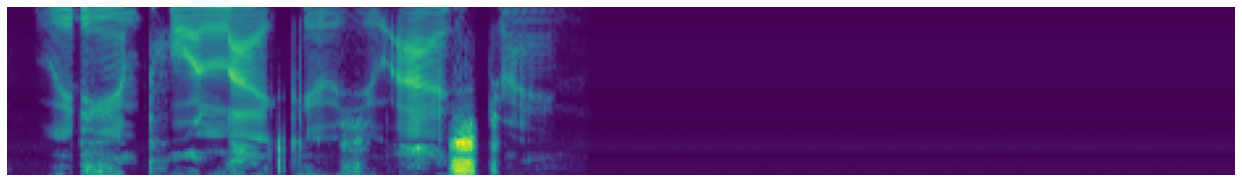

In [48]:
show_image(x[0], figsize = (22,45))

In [54]:
model = model.eval()
out = model(x).cpu()
model = model.train(True)

In [57]:
CTC = nn.CTCLoss(0)
def ctc_loss_no_lens(preds, targs):
    # preds = Tensor(torch.einsum("ijk->kij",preds).cpu())
    preds = F.log_softmax(preds, 1)
    preds = Tensor(preds.permute(2,0,1).cpu())
    preds_l = torch.full(fill_value = preds.shape[0], size = (preds.shape[1],) )#.cpu()
    # targs_l = torch.full(fill_value = targs.shape[1], size = (targs.shape[0],))#.cpu()
    targs_l = targs.argmin(1)
    targs_l = torch.where(targs[:,-1]==0, targs.argmin(1), targs.shape[1])-1
    return CTC(preds, targs, preds_l, targs_l)

In [58]:
def unpad(text):
    return Pad_Chunk(0).decode(text)

def ctc_decode(pred, empid = 0):
    pred = pred.argmax(0)
    dec = [empid]
    for i in range(len(pred)):
        cur = int(pred[i])
        if cur != dec[-1]: dec.append(cur)
    return [i for i in dec if i!=0]

def ids_to_str(ids):
    return ''.join([vocab[i] for i in ids])

In [59]:
def CER(inp, targ):
    inp,targ = inp.cpu(), targ.cpu()
    bs = inp.shape[0]
    cer = 0
    # for i,t in zip(inp,targ):
    for j in range(bs):
        i = list(ctc_decode(inp[j]))
        # print(j, i)
        t = list(int(i) for i in unpad(targ[j]))
        # print(t)
        # print(editdistance.eval(i,t))
        cer += editdistance.eval(i,t)/len(t)
    return cer / bs * 100

In [60]:
def ctc_accuracy(inp, targ):
    inp,targ = inp.cpu(), targ.cpu()
    bs = inp.shape[0]
    acc = 0
    for j in range(bs):
    # for i,t in zip(inp,targ):
        i = ids_to_str(ctc_decode(inp[j]))
        t = ids_to_str(unpad(targ[j]))
        acc += i==t
    return acc / bs

In [61]:
import wandb

In [62]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mizoru (use `wandb login --relogin` to force relogin)


True

In [63]:
wandb.init(name = 'thundertransform-quartz_5x3')

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [64]:
learn = Learner(dls, model, loss_func=ctc_loss_no_lens, metrics = [CER, ctc_accuracy],
             cbs=[WandbCallback()])#, SaveModelCallback(fname='thunder-QuartzNet_5x3-6')])

In [65]:
learn.freeze()

SuggestedLRs(valley=0.015848932787775993)

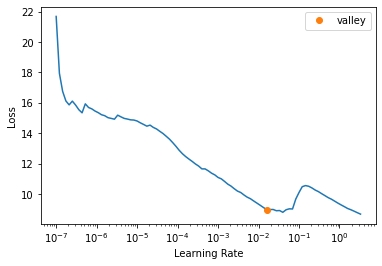

In [66]:
learn.lr_find()

In [67]:
learn.fit_one_cycle(2, 5e-3)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,4.683908,19.434599,99.915000,0.000000,01:43
1,3.897610,4.451197,100.000000,0.000000,01:29


WandbCallback was not able to get prediction samples -> Match length mismatch


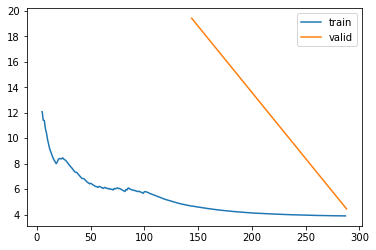

In [68]:
learn.recorder.plot_loss()

SuggestedLRs(valley=0.001737800776027143)

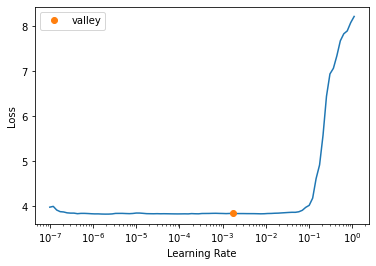

In [69]:
learn.lr_find()

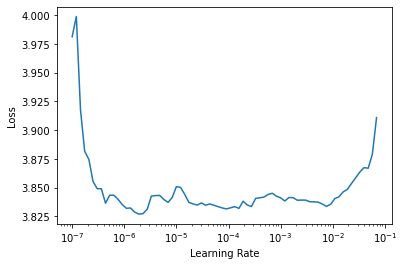

In [71]:
learn.recorder.plot_lr_find(20)

In [72]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,3.834008,4.325318,100.000000,0.000000,01:24
1,3.799603,4.253218,99.950157,0.000000,01:24
2,3.760883,4.243945,99.988607,0.000000,01:22


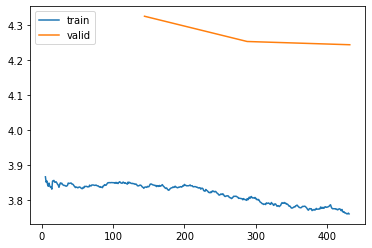

In [73]:
learn.recorder.plot_loss()

SuggestedLRs(valley=0.0003981071640737355)

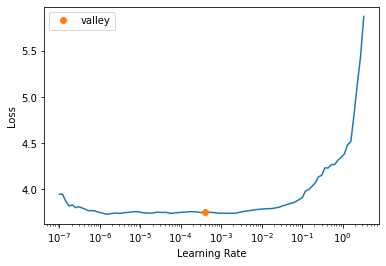

In [74]:
learn.lr_find()

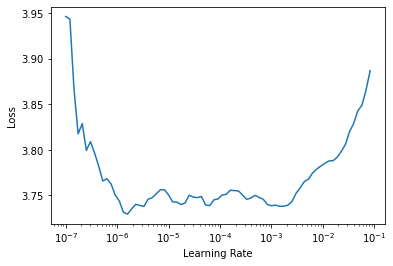

In [77]:
learn.recorder.plot_lr_find(25)

In [78]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,3.752234,4.393500,100.000000,0.000000,01:22
1,3.744519,8.530606,99.986807,0.000000,01:22
2,3.726375,4.267913,100.000000,0.000000,01:22
3,3.681382,4.932218,99.996865,0.000000,01:22
4,3.699871,10.277315,99.991341,0.000000,01:22


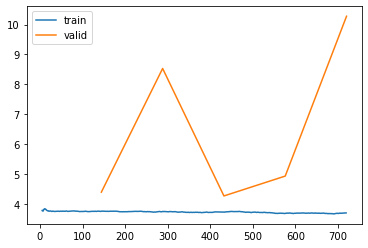

In [84]:
learn.recorder.plot_loss()

In [85]:
learn.unfreeze()

SuggestedLRs(valley=2.511886486900039e-05)

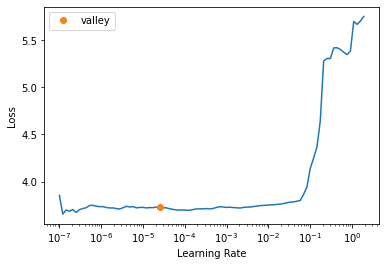

In [86]:
learn.lr_find()

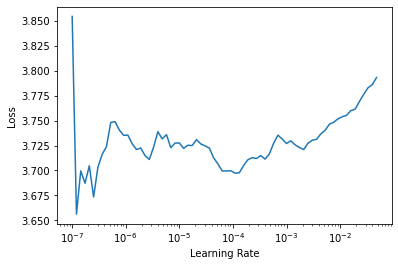

In [88]:
learn.recorder.plot_lr_find(25)

In [89]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,3.692030,8.890809,99.955928,0.000000,01:21
1,3.677613,13.255909,99.994919,0.000000,01:22
2,3.688134,10.325171,99.976076,0.000000,01:23
3,3.654222,12.361205,99.246400,0.000000,01:22
4,3.609291,15.170114,97.170551,0.000000,01:23
5,3.572146,11.823524,95.753428,0.000000,01:23
6,3.523370,5.836702,94.011863,0.000000,01:23
7,3.499564,4.475708,96.186882,0.000000,01:22
8,3.461693,6.682320,94.270787,0.000000,01:23
9,3.474769,6.465551,92.161563,0.000000,01:22


SuggestedLRs(valley=8.4139515820425e-05)

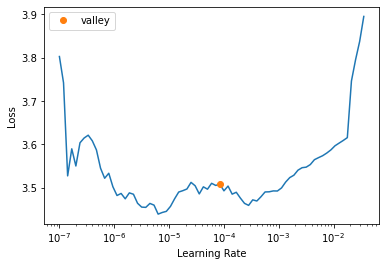

In [92]:
learn.lr_find(end_lr=1e-1, num_it=80)

In [93]:
learn.fit_one_cycle(10, 3e-5)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,3.457362,6.965188,91.712883,0.000000,01:20
1,3.483747,8.137284,91.051615,0.000000,01:21
2,3.458488,5.662117,91.082870,0.000000,01:22
3,3.459568,10.993371,91.496489,0.000000,01:23
4,3.466757,16.777208,90.476096,0.000000,01:23
5,3.407956,11.100308,89.728303,0.000000,01:23
6,3.431786,11.095466,88.561408,0.000000,01:23
7,3.401442,9.267173,89.913167,0.000000,01:23
8,3.390122,7.128493,89.541404,0.000000,01:23
9,3.349494,6.661291,91.205781,0.000000,01:23


In [96]:
learn.freeze()

SuggestedLRs(valley=5.754399353463668e-06)

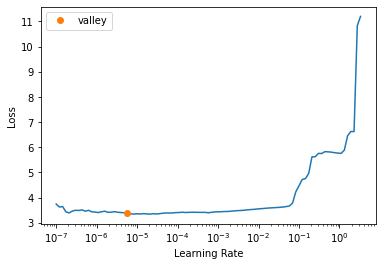

In [97]:
learn.lr_find()

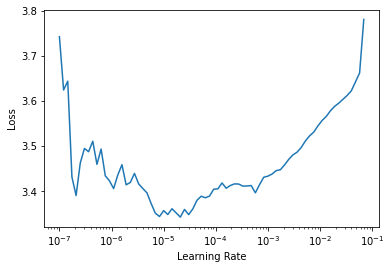

In [101]:
learn.recorder.plot_lr_find(29)

In [103]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(30, 2e-6)

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,3.391335,9.639022,88.907610,0.000000,01:20
1,3.356584,8.190649,90.460931,0.000000,01:21
2,3.352319,15.089853,89.178134,0.000000,01:22
3,3.371857,11.493418,88.972444,0.000000,01:23
4,3.352004,8.041842,89.082571,0.000000,01:23
5,3.401551,14.271611,88.420701,0.000000,01:23
6,3.388819,11.419193,89.657289,0.000000,01:23
7,3.385188,10.717631,89.642019,0.000000,01:23
8,3.369531,5.816680,88.617893,0.000000,01:23
9,3.391939,8.754855,89.821619,0.000000,01:23


In [92]:
wandb.init()

wandb: wandb version 0.12.16 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [93]:
learn.fit_one_cycle(50, 1e-5, cbs=[WandbCallback(), SaveModelCallback(fname='thunder-QuartzNet_5x3-6')])

epoch,train_loss,valid_loss,CER,ctc_accuracy,time
0,2.695801,3.107662,74.828031,0.000000,01:40
1,2.706864,3.064465,74.585959,0.000000,01:40
2,2.707616,3.087837,74.855972,0.000000,01:41
3,2.702869,3.072071,74.506638,0.000000,01:41
4,2.701746,3.107655,75.021063,0.000000,01:42
5,2.738884,3.110406,75.150083,0.000000,01:41
6,2.722144,3.062034,74.344414,0.000000,01:41
7,2.689133,3.122188,75.001235,0.000000,01:41
8,2.680029,3.086112,74.825672,0.000000,01:39
9,2.730103,3.094180,75.262956,0.000000,01:36


WandbCallback was not able to get prediction samples -> Match length mismatch
Better model found at epoch 0 with valid_loss value: 3.1076624393463135.
Better model found at epoch 1 with valid_loss value: 3.064464569091797.
Better model found at epoch 6 with valid_loss value: 3.0620338916778564.
Better model found at epoch 10 with valid_loss value: 3.052700996398926.


In [94]:
out = model.eval()(x).cpu()
print(CER(out[:], y[:]))

94.92015162280121


In [95]:
[(j,ids_to_str(ctc_decode(out[j]))) for j in range(out.shape[0])]

[(0, 'iw'),
 (1, 'i'),
 (2, 'ʃiɦd̚dɑk̚sgiw'),
 (3, ''),
 (4, ''),
 (5, 'ʃiɦd̚ɑk̚ksɡ̚griwɑʃwɔɾɚɔlj'),
 (6, ''),
 (7, 'i'),
 (8, 'ʃiɦd̚s'),
 (9, 'ʃiɦdɑrk̚ksʉiwɑw'),
 (10, 'ððaɪaɪ'),
 (11, 'ʃɑk̚ki'),
 (12, 'k̚griwɑʃwɔɾɚɔlj'),
 (13, 'ʃiɦdɑrk̚ksʉgiwʃ'),
 (14, 'k'),
 (15, ''),
 (16, 'griwɔʃwɔɾɚɔlj'),
 (17, 'ʃdɑrk̚ks'),
 (18, 'ʃiɦd̚dɑk̚sʉi'),
 (19, 'ʃiɦd̚dk̚si'),
 (20, 'giww'),
 (21, 'griwɔʃwɔɾɚɔlj'),
 (22, 'ʃis'),
 (23, 'ʃiɦdk̚si'),
 (24, 'ʃid̚d̚dɑrk̚s'),
 (25, ''),
 (26, 'ʃiɦd̚dɑrk̚ksʉgriwɑʃwɔɾɚɔlj'),
 (27, 'ʃiɦdk̚ksgiw'),
 (28, 'i'),
 (29, 'ʃiɦd̚dɑk̚ksgriwʃwɔɾɚɔlj'),
 (30, 'ʃid̚dɑk̚sgriwɔʃwɔɾɚɔlj'),
 (31, 'ʃiɦdk̚ksiw')]

In [71]:
wandb.finish()

CER,▂▁▁▁▂█▁▁▁▁▁▂▁▂▂▂▁▁▂▁▁▂▂▁▂▂▂▂▂▂
ctc_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▂▃▇██▇▆▆▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mom_0,▇▆▂▁▁▂▃▃▄▆▆▇██▇▃▁▁▁▂▃▄▅▆▇██▆▁▂▃▆██▃▁▂▄▇█
raw_loss,█▅▅▆▄▃▄▃▃▂▂▄▃▂▃▃▄▂▃▂▂▄▁▃▂▂▂▂▂▃▃▁▃▄▃▃▂▂▃▄
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wd_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [82]:
learn.save('QuartzNet_2x5_fin')

Path('models/QuartzNet_2x5_fin.pth')

In [75]:
preds,targs = learn.get_preds()

In [124]:
[ids_to_str(ctc_decode(preds[i])) for i in range(64,128)]

['wəlikɛtɨ̞tʉɪt',
 'ðikɨ̞t̚tɪtɑk',
 'wəɨ̞tɨ̞pɨ̞bɨ̞wɨ̞t̚kɨ̞d̚ɨ̞',
 'ʔəɨ̞mɔmɨ̞dɨ̞ɨ̞t',
 'ðɨ̞ɔtəkɑʔɔɔ',
 'ðiɪækɨ̞dɛɑ',
 'ʃiɦɛd̚djɚd̚dɑrk̚ksʉt̚ɨ̞ŋɡ̚grisiwɑʃwɔɾɚɔl',
 'ðəid̚tɨ̞baɪɾɚðɨ̞t̚tɨ̞',
 'ʔəɨ̞d̚tɨ̞pɨ̞bɔk̚kɨ̞ɨ̞',
 'wikiɨ̞tɨ̞tɨ̞',
 'ðɨ̞tɨ̞kəpɔwɔɑɨ̞',
 'ðiɪækɨ̞dɨ̞',
 'ðɨ̞rkɨ̞titɨ̞ɪt̚kɨ̞ɨ̞',
 'ðiiæɾɨ̞t',
 'ðɪkkɨ̞kɨ̞tɨ̞rɨ̞kɨ̞d̚ɨ̞',
 'ðət̚tɨ̞tɑdɨ̞k',
 'ʃiɦɛd̚jɚd̚dɑrk̚ksʉtɨ̞ɡ̚grisiwɑʃwɔɾɚɔl',
 'doʊɾ̃æsk̚miɾɨ̞k̚kɛriɨ̞nɔɪliræɡ̚glaɪk̚ð',
 'ðiiɨ̞bɨ̞dɔ',
 'ðirikɨ̞t̚titiɨ̞t̚t',
 'wɛidɨ̞tɨ̞bɨ̞rɨ̞t̚tii',
 'ðiɨ̞oʊbəvɛɨ̞',
 'ʔɑɨ̞bɔwaɪmɨ̞ʔɔkɨ̞ɨ̞',
 'waɪɨ̞ɝɨ̞vɛ',
 'wəɨ̞aɪvaɪmaɪ',
 'ðətɛkɨ̞diɪkəɨ̞',
 'ʃiɦæd̚dʒɚd̚dɑrk̚ksʉt̚ɨ̞nɡ̚grisiwɑʃwɔɾɚɔl',
 'doʊɾ̃æsk̚miɾɨ̞k̚kɛriɨ̞nʔɔɪliræɡ̚glaɪk̚ð',
 'ðibaɪədɨ̞kiɨ̞',
 'ðiiɨ̞tɨ̞tiɨ̞t̚tiɾi',
 'wəidɨ̞tɨ̞biɨ̞kɨ̞ɨ̞',
 'ʔɑɪtɪtibɛk',
 'ðəɨ̞bɛɨ̞daɪkəɨ̞t̚',
 'ðɨ̞pɨ̞bɨ̞mɨ̞rɑk',
 'rɨ̞kaɪkɨ̞tiɨ̞t̚ti',
 'brkɨ̞k̚kɛpɨ̞bɨ̞ɨ̞t̚tib̚ɨ̞',
 'ʃiɦæd̚jɚd̚dɑrk̚ksʉt̚ɨ̞nɡ̚grisiwɑʃwɔɾɚɔl',
 'doʊnæsk̚miɾɨ̞k̚kɛriɨ̞nʔɔɪliræɡ̚glaɪk̚ð',
 'wəlwɔwɨ̞d̚dɨ̞æəɨ̞',
 'wɑkʌɨ̞tɨ̞tɨ̞t',
 'ðit̚tɨ̞t̚tɪtɨ̞t̚ɪt̚ki

In [76]:
print('prediction', 'target', sep='\t')
print()
for i in range(0,101):
    print(*[ids_to_str(i) for i in (ctc_decode(preds[i]), unpad(targs[i]))], sep='\t\t')

prediction	target

ʃiɦæd̚dʒɚd̚dɑrk̚ksʉɨ̞nɡ̚grisiwɔʃwɔɾɚɔljɪ		ʃiɦæd̚djɝd̚dɑrk̚ksuɾɪŋɡ̚grisiwɑʃwɑɾɝʔɔljiɚ
doʊnæsk̚mit̚tɨ̞k̚kɛriɨ̞nɔɪliræɡ̚glaɪk̚ðæ		doʊnæsmit̚tɨ̞k̚kɛriɨ̞nɔɪliræɡ̚glaɪk̚kðæt̚
ðɪtɪtʔɛditɨ̞t		hɪzk̚kæp̚tɨ̞nwəsθɪnænɦæɡ̚gɝd̚dɨ̞nɪzb̚bjʉɾʉfl̩b̚but̚tswɚwɔrnɨ̞nʃæb̚bi
ðɪtɪkɨ̞kɨ̞t̚tɨ̞t̚tʉtɨ̞tɛ		ðɨ̞rizənzfɚðɪsd̚daɪvsimd̚dfulɨ̞ʃnaʊ
ðɨ̞rɪkɔlɨ̞tʉsɨ̞tɪ		pɚd̚dʌk̚kʃɨ̞nmeɪfɔlfɑrb̚bəloʊək̚ksp̚pɨ̞k̚teɪʃn̩t̚s
ðɨ̞tɪtip̚kɨ̞kɨ̞tɨ̞kɨ̞ʔɨ̞tɨ̞		pit̚sɚriɨ̞zɑrk̚kɨ̞nvinjɨ̞nt̚fɝɨ̞k̚kwɪk̚klʌnt̚tʃ
ðɨ̞tɪeɪt̚tɨ̞bɨ̞kiwɔ		pʊt̚ðəb̚bʊt̚tʃɚb̚blɑk̚teɪb̚bl̩ənðɨ̞ɡ̚gɝɑʃ
ðɨ̞tɪɛbɨ̞tɨ̞sɨ̞kɨ̞ðɨ̞		drɑp̚faɪvfɔrmzənðəb̚bɑk̚ksb̚bəfɔrjɨ̞ɡ̚goʊaʊt̚
ðəleɪitɨ̞kɨ̞tɨ̞pɨ̞tɨ̞pɨ̞		hɝwɔrd̚droʊb̚kn̩sɪsəvoʊnlisk̚kɝt̚tsənb̚blaʊsɨ̞ʔs
ðəweɪkɨ̞rɨ̞ʔɔlɛtɨ̞tɨ̞		ʔɛld̚dɝlip̚pip̚pl̩ɝɑfɨ̞nɨ̞ʔk̚ksk̚klʉd̚dɨ̞d̚d
ʃiɦæd̚jɚd̚dɑrk̚ksʉɛʔɛili		ʃiɦæd̚djʊd̚dæk̚ksʉt̚ɪnɡ̚grisiwɑʃwɔɾʌʔɔljɪɝ
doʊnæsk̚mit̚tɨ̞k̚kɛriɨ̞nɔɪliræɡ̚glaɪk̚ðæ		doʊnʔæsmiɾɪk̚kæriɨ̞nɔɪliræɡ̚glaɪk̚θæt̚
ðɨ̞tɪpilɔbɨ̞tʉsɨ̞tɪ		hʌsk̚kijʌŋmænɦisɛd̚wɪðmɑk̚dɪst̚teɪst̚t
ðərɪt̚tɨ̞tɨ̞tɨ̞kɛʔɨ̞ɨ̞		ɑɦɑhiθɔt̚ʔ